In [9]:
import torch
import pandas as pd
import numpy as np
from transformers import MobileViTImageProcessor
import os
from dataset import MRIImageDataModule
from models import MobileViTLightning, EfficientNetBaseline
from utils import get_best_device

# Set device
device = get_best_device()

# Path to the CSV file
csv_path = 'Data/metadata_for_preprocessed_files.csv'

# Define the models and slices
model_configs = {
    'MobileVit': {
        'model_ckpt': 'apple/mobilevit-small',
        'slice_numbers': ['65', '86', '56', '95', '62', '35', '59', '74', '80', '134']
    },
    'EfficientNetb0': {
        'model_ckpt': None,
        'slice_numbers': ['65', '86', '56', '95', '62', '35', '59', '74', '80', '134']
    }
}

# Load and preprocess the MRI dataset
def get_transform(model_name, model_ckpt):
    if model_name == "MobileVit":
        processor = MobileViTImageProcessor.from_pretrained(model_ckpt)
        return lambda image: processor(image, return_tensors="pt")["pixel_values"].squeeze(0)
    elif model_name == 'EfficientNetb0':
        return None

# Function to apply softmax after averaging predictions
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=-1, keepdims=True)

# Iterate over the models and slices
for model_name, config in model_configs.items():
    model_ckpt = config['model_ckpt']
    transform = get_transform(model_name, model_ckpt)
    results_dict = {'id': [], 'labels': []}
    model_predictions = []
    
    # Initialize a dictionary to store slice predictions
    slice_predictions = {f'slice_{slice_number}': [] for slice_number in config['slice_numbers']}

    for slice_number in config['slice_numbers']:
        model_path = f'model_checkpoints/{model_name}/slice_numer_{slice_number}.ckpt'
        if not os.path.exists(model_path):
            continue
        
        # Load the model
        if model_name == "MobileVit":
            model = MobileViTLightning.load_from_checkpoint(model_path, model_ckpt=model_ckpt, num_labels=4)
        elif model_name == 'EfficientNetb0':
            model = EfficientNetBaseline.load_from_checkpoint(model_path)

        model = model.to(device)
        model.eval()

        # Initialize the data module
        data_module = MRIImageDataModule(csv_path, slice_number=int(slice_number), transform=transform, batch_size=48, num_workers=0)
        data_module.setup()
        test_loader = data_module.test_dataloader()

        # Perform inference and store predictions
        all_preds = []
        all_labels = []
        all_ids = []
        
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels, age, ids = batch
                inputs = inputs.to(device).float()
                outputs = model(inputs)
                all_preds.extend(outputs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_ids.extend(ids)

        # Store predictions
        model_predictions.append(all_preds)
        slice_predictions[f'slice_{slice_number}'].extend(all_preds)
        if not results_dict['id']:
            results_dict['id'] = all_ids
            results_dict['labels'] = all_labels

    # Average predictions for each model and slice combination
    averaged_predictions = np.mean(model_predictions, axis=0)
    final_predictions = softmax(averaged_predictions)  # Apply softmax

    results_dict[model_name] = final_predictions.tolist()

    # Add individual slice predictions to the results_dict
    for slice_number in config['slice_numbers']:
        if f'slice_{slice_number}' in slice_predictions:
            results_dict[f'slice_{slice_number}'] = [str(pred.tolist()) for pred in slice_predictions[f'slice_{slice_number}']]

    # Convert dictionary to DataFrame
    df_results = pd.DataFrame(results_dict)

    # Ensure rows are sorted by MRI ID
    df_results = df_results.sort_values(by='id')

    # Save DataFrame to CSV
    df_results.to_csv(f'{model_name}_predictions.csv', index=False)

    # Display DataFrame
    print(df_results.head())


/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([4, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecat

              id  labels                                          MobileVit  \
0  OAS1_0015_MR1       1  [0.28569620847702026, 0.5377851724624634, 0.16...   
1  OAS1_0018_MR1       0  [0.9905146360397339, 0.008641750551760197, 0.0...   
2  OAS1_0030_MR1       0  [0.9208735227584839, 0.07235926389694214, 0.00...   
3  OAS1_0032_MR1       0  [0.23094747960567474, 0.4490777254104614, 0.28...   
4  OAS1_0042_MR1       1  [0.24557006359100342, 0.49243831634521484, 0.2...   

                                            slice_65  \
0  [1.0059000253677368, 1.9615592956542969, 0.518...   
1  [4.650204658508301, 0.23598213493824005, -1.65...   
2  [3.476705312728882, 1.7580922842025757, -1.163...   
3  [0.40554115176200867, 0.8600465059280396, 0.44...   
4  [0.32260119915008545, 1.095572590827942, 0.311...   

                                            slice_86  \
0  [0.8037562966346741, 0.9597938060760498, 0.026...   
1  [5.178120136260986, -0.10166832059621811, -2.1...   
2  [3.30907440185546

/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

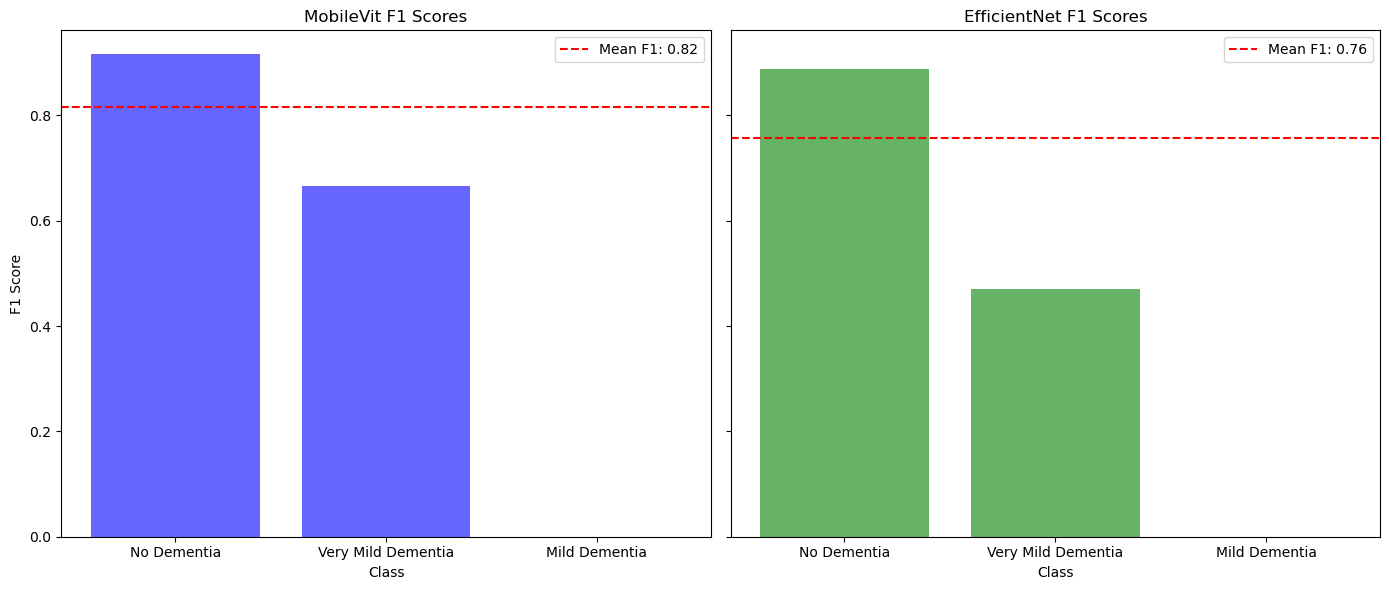

MobileVit Mean F1 Score: 0.8159182183278569
MobileVit Class-wise F1 Scores: {'0': 0.9156626506024096, '1': 0.6666666666666667, '2': 0.0}
EfficientNet Mean F1 Score: 0.7567439096850863
EfficientNet Class-wise F1 Scores: {'0': 0.888888888888889, '1': 0.4705882352941177, '2': 0.0}


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Load the CSV files into dataframes
mobilevit_df = pd.read_csv('MobileVit_predictions.csv')
efficientnet_df = pd.read_csv('EfficientNetb0_predictions.csv')

# Extract labels and predictions
y_true_mobilevit = mobilevit_df['labels'].tolist()
y_pred_mobilevit = mobilevit_df['MobileVit'].apply(eval).apply(np.argmax).tolist()

y_true_efficientnet = efficientnet_df['labels'].tolist()
y_pred_efficientnet = efficientnet_df['EfficientNetb0'].apply(eval).apply(np.argmax).tolist()

# Calculate F1 scores for MobileVit
report_mobilevit = classification_report(y_true_mobilevit, y_pred_mobilevit, output_dict=True)
mean_f1_mobilevit = report_mobilevit['weighted avg']['f1-score']
class_f1_mobilevit = {k: v['f1-score'] for k, v in report_mobilevit.items() if k.isdigit()}

# Calculate F1 scores for EfficientNet
report_efficientnet = classification_report(y_true_efficientnet, y_pred_efficientnet, output_dict=True)
mean_f1_efficientnet = report_efficientnet['weighted avg']['f1-score']
class_f1_efficientnet = {k: v['f1-score'] for k, v in report_efficientnet.items() if k.isdigit()}

# Prepare data for plotting
labels = sorted(set(y_true_mobilevit + y_true_efficientnet))
class_labels = ["No Dementia", "Very Mild Dementia", "Mild Dementia"]
mobilevit_scores = [class_f1_mobilevit.get(str(label), 0) for label in labels]
efficientnet_scores = [class_f1_efficientnet.get(str(label), 0) for label in labels]

# Plotting the results
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# MobileVit plot
axes[0].bar(labels, mobilevit_scores, color='blue', alpha=0.6)
axes[0].axhline(mean_f1_mobilevit, color='red', linestyle='--', label=f'Mean F1: {mean_f1_mobilevit:.2f}')
axes[0].set_title('MobileVit F1 Scores')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('F1 Score')
axes[0].set_xticks(labels)
axes[0].set_xticklabels(class_labels)
axes[0].legend()

# EfficientNet plot
axes[1].bar(labels, efficientnet_scores, color='green', alpha=0.6)
axes[1].axhline(mean_f1_efficientnet, color='red', linestyle='--', label=f'Mean F1: {mean_f1_efficientnet:.2f}')
axes[1].set_title('EfficientNet F1 Scores')
axes[1].set_xlabel('Class')
axes[1].set_xticks(labels)
axes[1].set_xticklabels(class_labels)
axes[1].legend()

plt.tight_layout()
plt.show()

# Display mean F1 scores and class-wise F1 scores
print("MobileVit Mean F1 Score:", mean_f1_mobilevit)
print("MobileVit Class-wise F1 Scores:", class_f1_mobilevit)

print("EfficientNet Mean F1 Score:", mean_f1_efficientnet)
print("EfficientNet Class-wise F1 Scores:", class_f1_efficientnet)


/var/folders/l5/4bf7qdjd6k9b38g7jlnrcf580000gn/T/ipykernel_89470/647778405.py:44: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Random Searching Weights:   0%|          | 0/20000 [00:00<?, ?it/s]

Best Weights for MobileVit: [0.0404362  0.18625827 0.00163667 0.10006209 0.00941306 0.15080377
 0.02163327 0.16248354 0.318996   0.00827714]


Random Searching Weights:   0%|          | 0/20000 [00:00<?, ?it/s]

Best Weights for EfficientNet: [0.01393197 0.07328875 0.00365835 0.10305215 0.02867582 0.08147641
 0.29054409 0.00267899 0.26893823 0.13375523]
Weighted F1 Score for MobileVit: 0.8897811447811448
Weighted F1 Score for EfficientNet: 0.8664784490871448


/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

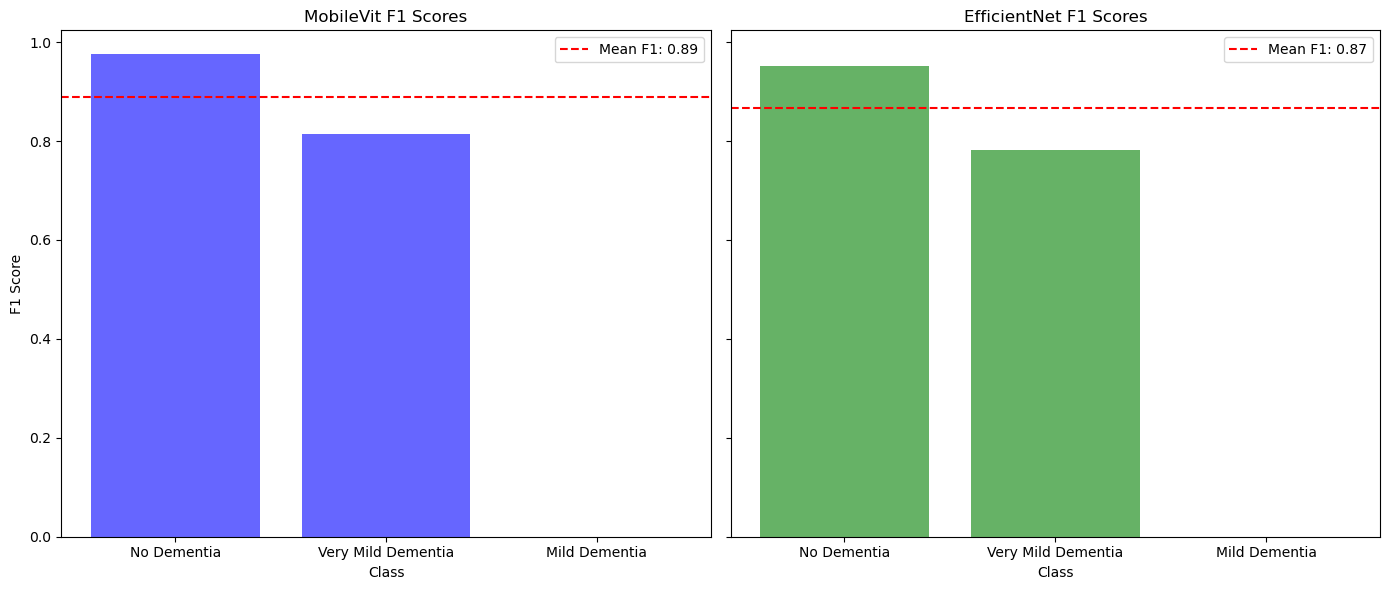

MobileVit Mean F1 Score: 0.8897811447811448
MobileVit Class-wise F1 Scores: {'0': 0.975, '1': 0.8148148148148148, '2': 0.0}
EfficientNet Mean F1 Score: 0.8664784490871448
EfficientNet Class-wise F1 Scores: {'0': 0.9523809523809524, '1': 0.7826086956521738, '2': 0.0}


In [24]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter notebooks

# Load the CSV files into dataframes
mobilevit_df = pd.read_csv('MobileVit_predictions.csv')
efficientnet_df = pd.read_csv('EfficientNetb0_predictions.csv')

# Extract labels and slice predictions
y_true_mobilevit = mobilevit_df['labels'].tolist()
slice_predictions_mobilevit = [mobilevit_df[f'slice_{slice_number}'].apply(eval).tolist() for slice_number in ['65', '86', '56', '95', '62', '35', '59', '74', '80', '134']]

y_true_efficientnet = efficientnet_df['labels'].tolist()
slice_predictions_efficientnet = [efficientnet_df[f'slice_{slice_number}'].apply(eval).tolist() for slice_number in ['65', '86', '56', '95', '62', '35', '59', '74', '80', '134']]

def calculate_f1_for_weights(weights, slice_predictions, y_true):
    weighted_preds = np.average(slice_predictions, axis=0, weights=weights)
    y_pred = np.argmax(weighted_preds, axis=1)
    return f1_score(y_true, y_pred, average='weighted')

def generate_random_weight_combinations(num_slices, num_combinations=20000):
    random_combinations = []
    for _ in range(num_combinations):
        weights = np.random.dirichlet(np.ones(num_slices), size=1)[0]
        random_combinations.append(weights)
    return random_combinations

def random_search_best_weights(slice_predictions, y_true, num_combinations=20000):
    num_slices = len(slice_predictions)
    best_f1 = 0
    best_weights = None
    random_combinations = generate_random_weight_combinations(num_slices, num_combinations)
    
    for weights in tqdm(random_combinations, desc="Random Searching Weights"):
        f1 = calculate_f1_for_weights(weights, slice_predictions, y_true)
        if f1 > best_f1:
            best_f1 = f1
            best_weights = weights

    return best_weights

# Ensure tqdm notebook display works
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Find best weights for MobileVit
best_weights_mobilevit = random_search_best_weights(slice_predictions_mobilevit, y_true_mobilevit)
print("Best Weights for MobileVit:", best_weights_mobilevit)

# Find best weights for EfficientNet
best_weights_efficientnet = random_search_best_weights(slice_predictions_efficientnet, y_true_efficientnet)
print("Best Weights for EfficientNet:", best_weights_efficientnet)

# Calculate weighted predictions
weighted_preds_mobilevit = np.average(slice_predictions_mobilevit, axis=0, weights=best_weights_mobilevit)
weighted_preds_efficientnet = np.average(slice_predictions_efficientnet, axis=0, weights=best_weights_efficientnet)

# Convert to class predictions
y_pred_mobilevit = np.argmax(weighted_preds_mobilevit, axis=1)
y_pred_efficientnet = np.argmax(weighted_preds_efficientnet, axis=1)

# Calculate and print F1 scores
f1_mobilevit = f1_score(y_true_mobilevit, y_pred_mobilevit, average='weighted')
f1_efficientnet = f1_score(y_true_efficientnet, y_pred_efficientnet, average='weighted')

print("Weighted F1 Score for MobileVit:", f1_mobilevit)
print("Weighted F1 Score for EfficientNet:", f1_efficientnet)

# Calculate F1 scores for MobileVit
report_mobilevit = classification_report(y_true_mobilevit, y_pred_mobilevit, output_dict=True)
mean_f1_mobilevit = report_mobilevit['weighted avg']['f1-score']
class_f1_mobilevit = {k: v['f1-score'] for k, v in report_mobilevit.items() if k.isdigit()}

# Calculate F1 scores for EfficientNet
report_efficientnet = classification_report(y_true_efficientnet, y_pred_efficientnet, output_dict=True)
mean_f1_efficientnet = report_efficientnet['weighted avg']['f1-score']
class_f1_efficientnet = {k: v['f1-score'] for k, v in report_efficientnet.items() if k.isdigit()}

# Prepare data for plotting
labels = sorted(set(y_true_mobilevit + y_true_efficientnet))
class_labels = ["No Dementia", "Very Mild Dementia", "Mild Dementia"]
mobilevit_scores = [class_f1_mobilevit.get(str(label), 0) for label in labels]
efficientnet_scores = [class_f1_efficientnet.get(str(label), 0) for label in labels]

# Plotting the results
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# MobileVit plot
axes[0].bar(labels, mobilevit_scores, color='blue', alpha=0.6)
axes[0].axhline(mean_f1_mobilevit, color='red', linestyle='--', label=f'Mean F1: {mean_f1_mobilevit:.2f}')
axes[0].set_title('MobileVit F1 Scores')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('F1 Score')
axes[0].set_xticks(labels)
axes[0].set_xticklabels(class_labels)
axes[0].legend()

# EfficientNet plot
axes[1].bar(labels, efficientnet_scores, color='green', alpha=0.6)
axes[1].axhline(mean_f1_efficientnet, color='red', linestyle='--', label=f'Mean F1: {mean_f1_efficientnet:.2f}')
axes[1].set_title('EfficientNet F1 Scores')
axes[1].set_xlabel('Class')
axes[1].set_xticks(labels)
axes[1].set_xticklabels(class_labels)
axes[1].legend()

plt.tight_layout()
plt.show()

# Display mean F1 scores and class-wise F1 scores
print("MobileVit Mean F1 Score:", mean_f1_mobilevit)
print("MobileVit Class-wise F1 Scores:", class_f1_mobilevit)

print("EfficientNet Mean F1 Score:", mean_f1_efficientnet)
print("EfficientNet Class-wise F1 Scores:", class_f1_efficientnet)